In [1]:
%%time
%run -i 'myimports.py'
%run -i 'nlp_processing.py'
%run -i "datagathering"
%run -i 'timestamp_generation.py'


def coordinates(title):
    return [40, 220, 150, 300, 183, 494] #first last pages, x coord and width, y coord and height

def create_txt(title):
    if not os.path.isfile(title+".txt"):
        if os.path.isfile(title+".pdf"):
            c = coordinates(title+".pdf")
            convert = "pdftotext -f %d -l %d -x %d -W %d -y %d -H %d %s.pdf" %(c[0],c[1],c[2],c[3],c[4],c[5],title)
            process = subprocess.Popen(convert.split(), stdout=subprocess.PIPE)
            output, error = process.communicate()

contents = ["Introduction",
            "The Negro and Language",
            "The Woman of Color and the White Man",
            "The Man of Color and the White Woman",
            "The So-Called Dependency Complex of Colonized Peoples",
            "The Fact of Blackness",
            "The Negro and Psychopathology",
            "The Negro and Recognition",
            "By Way of Conclusion"]
contents = [x.upper() for x in contents]
the_regex = "r"+("\s|".join(re.escape(s) for s in contents))

KeyboardInterrupt: 

NameError: name 'nlp' is not defined

CPU times: user 1.49 s, sys: 841 ms, total: 2.33 s
Wall time: 3.7 s


In [2]:
full_text = ""
with open("black.txt", "r") as r:
#     full_text = r.read().replace("INTRODUCTION", "").replace("\n"," ").replace(". . . ", "")
    lines = r.readlines()
    for line in lines:
        full_text +=line.replace("\n", " ")
full_text = full_text.replace("INTRODUCTION", "").replace(". . . ", "")
full_text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', full_text)

FileNotFoundError: [Errno 2] No such file or directory: 'black.txt'

In [13]:
text_split = re.split(the_regex, full_text)

In [14]:
for ind, i in enumerate(text_split):
    with open("chapters/"+str(ind)+"_"+contents[ind].replace(" ", "_")+".txt", "w+") as f:
        f.write(i)

In [2]:
only_files = []
for file in listdir("chapters"):
    if file.endswith(".txt"):
        only_files.append([open("chapters/"+file).read(), file])
#         only_files.append(open("chapters/"+file).read())



In [6]:
podcast_name = "chapters"
# os.listdir(podcast_name)
onlyfiles = folder_to_filelist(podcast_name)
# print(onlyfiles[0]) #works

doc_bin = DocBin(store_user_data=True) #docbin container for serialization
docs = [] #list of docs 
print("starting")
for doc, name in nlp.pipe(onlyfiles, as_tuples=True): #piping all collection of docs to make doclist and docbin
    #each doc contians hostname, guest, title, entities mentioned, and summary
    name = re.split("[.\|]",name)[:-1]
    name=name[1:] if name[0][1:].isdigit() else name # store name of guest and topic, add to doc user data
    
#     doc.user_data["host"] = podcast_host
#     doc.user_data["guest"]= str(name[0]).replace("_"," ")
    doc.user_data["title"]= str(name)
    doc.user_data["entis"] = [(ent.text, ent.label_) for ent in doc.ents]
    doc = keep_ents(doc) #extract and save all entities by filtering entity extraction
    docs.append(doc)
    doc_bin.add(doc) #add doc to list and bin
print("done")    
with open("cucumber/book_doc.bin", "wb") as f: #write bytestream to first_doc.bin
    f.write(doc_bin.to_bytes())

starting


/ilab/users/hs884/.local/lib/python3.8/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /ilab/users/hs884/.local/lib/python3.8/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


done


In [25]:
for d in docs:
    d.user_data["guest"] = "fanon"
for d in docs:
    print(d.user_data["books"])

['Pigalle', 'Marseille', 'New York', 'Antilles', 'Antilles', 'the Negro of Africa']
['Paris', 'Paris', 'Paris', 'Paris', 'Martinique', 'Marigot', 'Gros-Morne', 'Paris', 'Gallimard', 'France', 'France', 'France', 'Le Havre', 'Marseille', 'Antilles', 'Martinique', 'France', 'ed.', 'Paris', 'Universitaires de France', 'Antilles', 'France', 'Martinique', 'France', 'Martinique', 'Europe', 'France', 'Paris', 'Prsence Africaine', 'the United States', 'France', 'France', 'France', 'Tabernacle', 'France', 'France', 'Panissires', 'France', 'Paris', 'Marseille', 'Pigalle', 'France', 'Savannah', 'Savannah', 'Savannah', 'France', 'Antilles', 'Congo', 'Antilles', 'the Antilles Negro', 'France', 'Martinique', 'the Antilles Negro', 'Orphe Noir', 'Antilles', 'Martinique-Guadeloupe-Haiti', 'Senegal', 'Antilles', 'Antilles', 'Brittany', 'Antilles', 'Nairobi', 'the Kingdom of Heaven', 'London', 'Lyon', 'France', 'Savannah', 'Savannah', 'Rouen', 'Strasbourg', 'Africa', 'Dakar', 'Rufisque', 'Negro', 'France

In [68]:
att_to_csv(docs, "people")

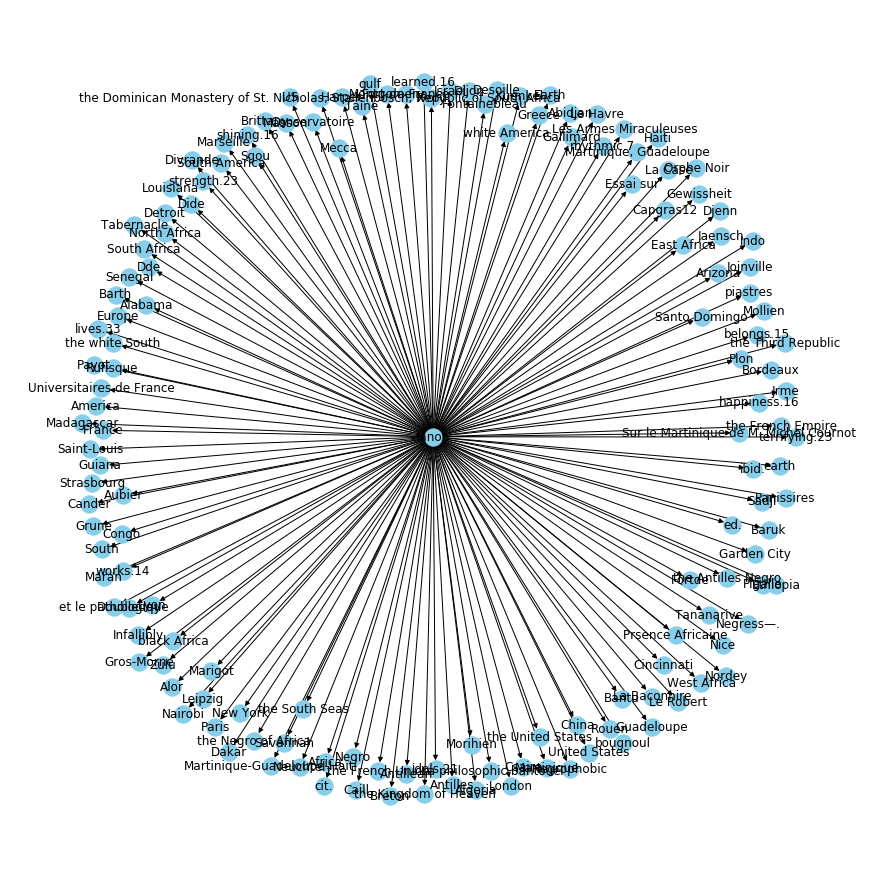

In [70]:
#generate megagraph for book ents
edges = pd.read_csv("placesEdges.csv", sep=',').drop("id", axis=1).values.tolist()
nodes = pd.read_csv('placesNodes.csv',sep=',').set_index("id").to_dict("index")

source = [nodes.get(e[0])["name"] for e in edges]
target = [nodes.get(e[1])["name"] for e in edges]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':np.ones(len(source))})
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#following are other example graphviews

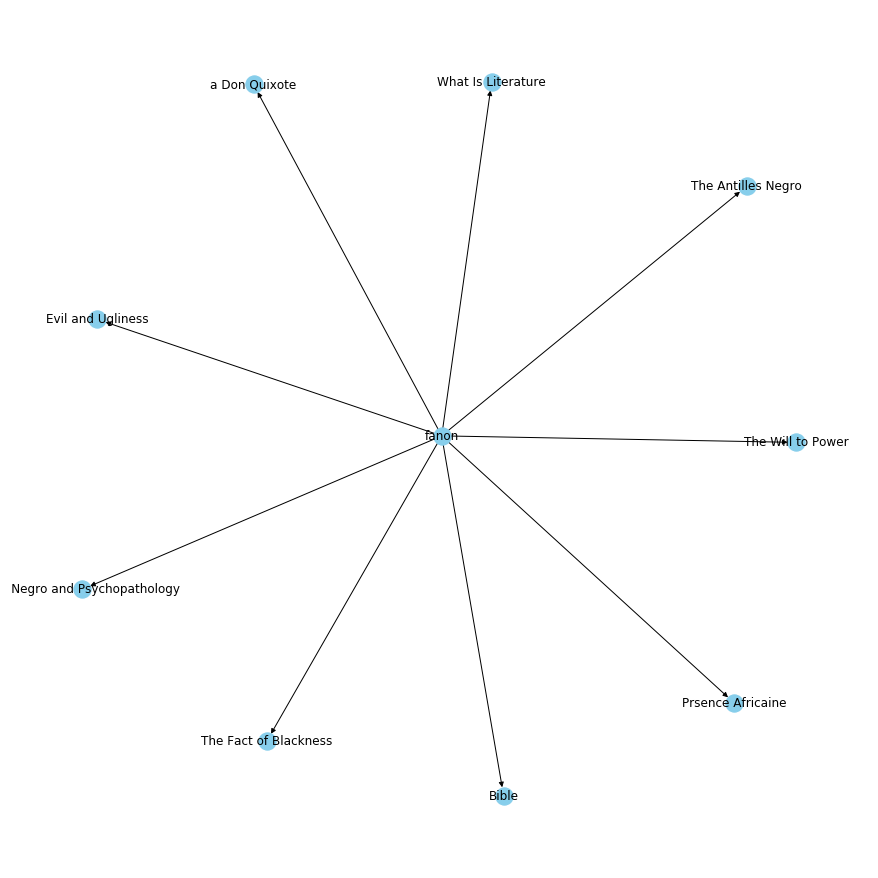

In [28]:
#generate megagraph for book ents
edges = pd.read_csv("booksEdges.csv", sep=',').drop("id", axis=1).values.tolist()
nodes = pd.read_csv('booksNodes.csv',sep=',').set_index("id").to_dict("index")

source = [nodes.get(e[0])["name"] for e in edges]
target = [nodes.get(e[1])["name"] for e in edges]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':np.ones(len(source))})
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#following are other example graphviews

In [2]:
full_doc = nlp(open("black.txt").read().replace("\n"," "))

/ilab/users/hs884/.local/lib/python3.8/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /ilab/users/hs884/.local/lib/python3.8/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [53]:

def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
                
    return result # 5

get_hotwords(open("black.txt").read().replace("\n"," "))

['introduction',
 'millions',
 'men',
 'fear',
 'inferiority',
 'complexes',
 'trepidation',
 'servility',
 'despair',
 'abasement',
 'aimé',
 'césaire',
 'le',
 'colonialisme',
 'explosion',
 'today',
 'timeless',
 'truths',
 'consciousness',
 'ultimate',
 'radiances',
 'complete',
 'composure',
 'good',
 'certain',
 'things',
 'things',
 'long',
 'time',
 'shouting',
 'life',
 'book',
 'idiots',
 'world',
 'burden',
 'new',
 'humanism',
 'understanding',
 'men',
 'colored',
 'brothers',
 'mankind',
 'race',
 'prejudice',
 'sides',
 'dozens',
 'hundreds',
 'pages',
 'wills',
 'single',
 'line',
 'single',
 'answer',
 'color',
 'problem',
 'importance',
 'man',
 'black',
 'man',
 'risk',
 'resentment',
 'colored',
 'brothers',
 'black',
 'man',
 'zone',
 'nonbeing',
 'sterile',
 'arid',
 'region',
 'naked',
 'declivity',
 'authentic',
 'upheaval',
 'cases',
 'black',
 'man',
 'advantage',
 'able',
 'descent',
 'real',
 'hell',
 'man',
 'possibility',
 'recapture',
 'negation',
 'true',

In [3]:
sents = [sent.text for sent in full_doc.sents]
dictionary, model = generate_model("black.txt", 2700)
one_topic_confi = load_confidences("black.txt", dictionary, model, sents, basic_completion) #generate initial topics + confidences, then smooth by filling in empty values and averaging


algo_stamps = get_algo_timestamps(one_topic_confi) #algo generated timestamps with sentence marker
proce = get_stamp_summaries(algo_stamps, sents)


# actual_stamps = get_real_timestamps(soup, sents, timesfolder, file) #description generated timestamps



56.6875


In [23]:
# for index in range(len(model)):
#     print("Topic: {}\t Words: {}".format(index, model.print_topic(index, 5)))
for topic, doc in zip(algo_stamps[:,1],proce):
    print(topic,"\n",model.print_topic(topic, 5),"\n\n", doc.user_data["summary"],"\n")

7 
 0.010*"languag" + 0.008*"chapter" + 0.005*"prove" + 0.005*"colon" + 0.005*"root" 

 ['The black is a black man; that is, as the result of a series of aberrations of affect, he is rooted at the core of a universe from which he must be extricated.', 'I take the black man of today and i try to establish his attitudes in the white world.', 'A negro behaves differently with a white man and with another negro.', 'Conversely, the black man who wants to turn his race white is as miserable as he who preaches hatred for the whites.', 'To us, the man who adores the negro is as “sick” as the man who abominates him.'] 

4 
 0.007*"nigger" + 0.005*"famili" + 0.005*"senegales" + 0.004*"normal" + 0.004*"mannoni" 

 ['In a more limited group, when students from the antilles meet in paris, they have the choice of two possibilities: —either to stand with the white world (that is to say, the real world), and, since they will speak french, to be able to confront certain problems and incline to a certai

In [6]:
%%time
actual_stamps = []
for ind, sent in enumerate(sents):
    for chap in contents:
        if chap in sent:
            print(chap, ind)
            actual_stamps.append(ind)

INTRODUCTION 0
THE NEGRO AND LANGUAGE 169
THE WOMAN OF COLOR AND THE WHITE MAN 592
THE MAN OF COLOR AND THE WHITE WOMAN 1037
THE FACT OF BLACKNESS 1998
THE NEGRO AND PSYCHOPATHOLOGY 2753
THE NEGRO AND RECOGNITION 4104
BY WAY OF CONCLUSION 4376
CPU times: user 13.3 ms, sys: 3.42 ms, total: 16.7 ms
Wall time: 14.8 ms


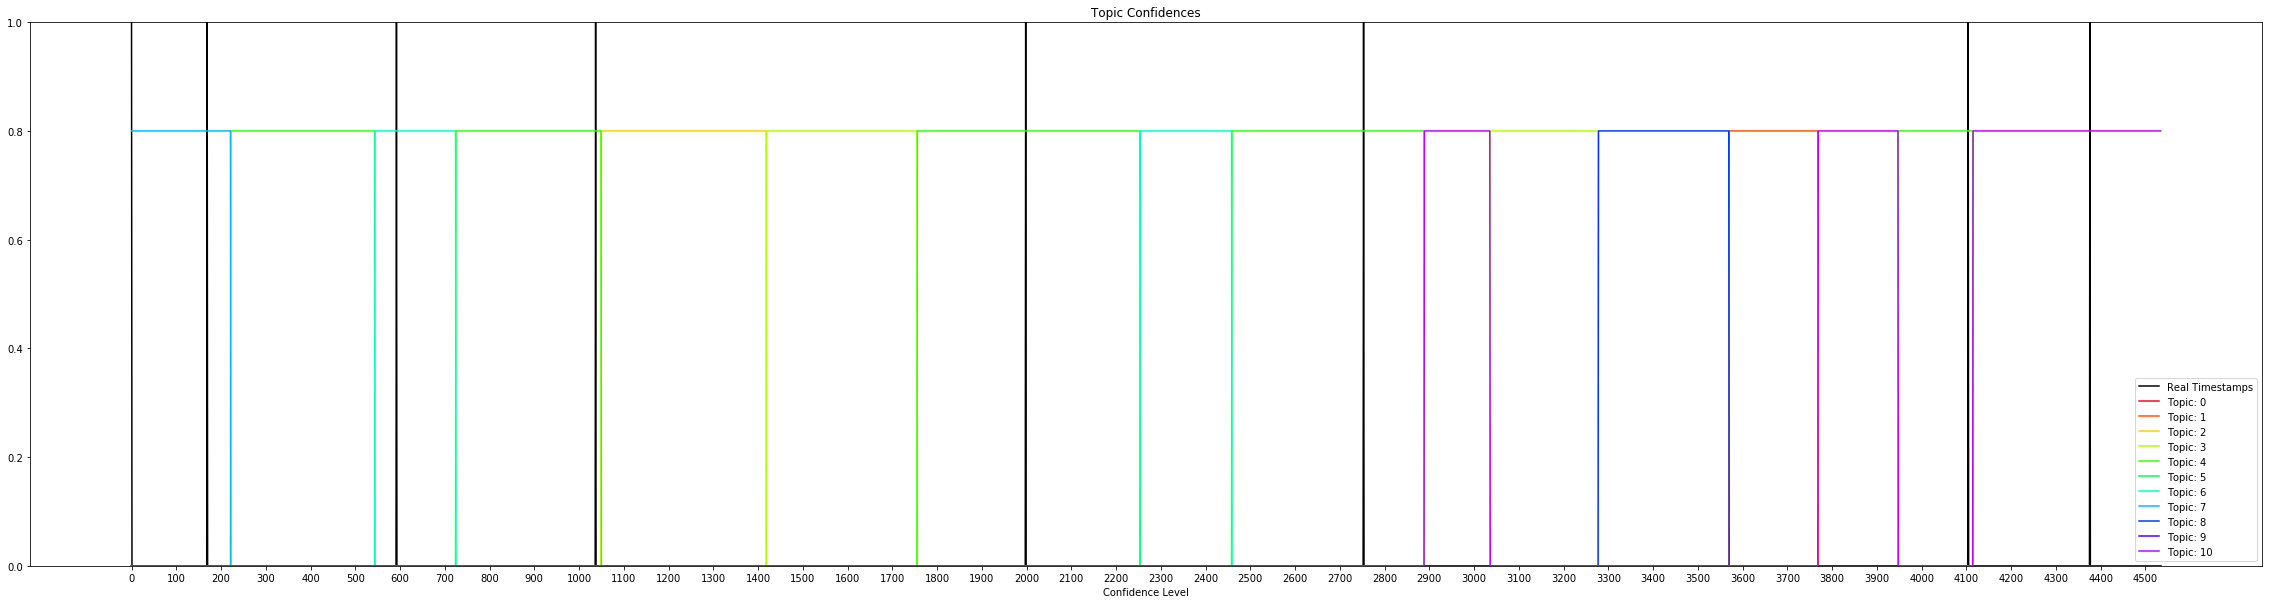

In [8]:
final_topic_confi = get_final_topic_confi(sents, algo_stamps) #new topic graph based on algo timestamps
top_confi = np.zeros([int(math.log(pod_word_count("black.txt"))), len(sents)]) #2d array of confidences for each topic

NUM_COLORS = int(math.log(pod_word_count("black.txt")))

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.title("Topic Confidences")
plt.xlabel("Sentence Number")
plt.xticks(np.arange(0, len(sents), 100))
plt.xlabel("Confidence Level")
plt.ylim(0,1)

r1, r2 = 0, len(sents)
# r1, r2 = 150, 200
x = np.arange(0, len(sents))
plt.plot(x[r1:r2], convert_to_gra(actual_stamps, sents)[r1:r2], label="Real Timestamps", color="black") #graph original timestamps in black
# plt.plot(x[r1:r2], final_topic_confi[r1:r2], label="Model", color="dimgrey")



for ind, i in enumerate(final_topic_confi): #set graph
    top_confi[int(i)][ind] = .8
    
for i in range(int(math.log(pod_word_count("black.txt")))): #graph the timestamps as according to algorithm, each color corresponds to a new topic
    plt.plot(x[r1:r2],top_confi[i][r1:r2], label="Topic: "+str(i))

plt.legend()
plt.rcParams['figure.figsize'] = [40, 10]
plt.show()